<a href="https://colab.research.google.com/github/Tushaam/JAX-tutorials/blob/main/LSTM_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First we will understand how LSTM's gates work to code it in JAX

1) **Forget gate**: This decides what info is to be forgotten from the cell state. Here we use sigmoid activation to choose if info is to be kept or forgotten. If the output is **0**, forget it. If it's **1** then keep it.

2) **Input gate**: This chooses what info is to be kept in the next cell state. Well you can consider this like a high level filter that decides what info from the current input is to be added to the long term memory of the network.We use both sigmoid and tanh activations here. Sigmoid for the same task as that in forget gate but **tanh is for control**. It outputs values between [-1,1]. If a feature is assigned -1, it means it has negligible impact on the output and hence can be ignored. While 1 means high importance feature.

3) **Update gate**: This updates the cell state with input from the forget & input gate. Basically this is for flexibility which enables model to update the memory based on context. Without this model would be static-- Info is neither forgotten nor updated

4) **Output gate**: This decides what the next hidden state should be. Because we are well aware that at each timestep,we dont process entire sequence, but rather a small chunk of it. Without this gate maybe each info would be passed for processing and all of it might not be important at that timestep.

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from typing import Tuple


# Let us begin by building each gate of the LSTM

how we will proceed:

we will build forget gate foremost:

1) We will concatenate the previous hidden state with current state input
2) multiply this concatenated value with eight matrix
3) add bias to it

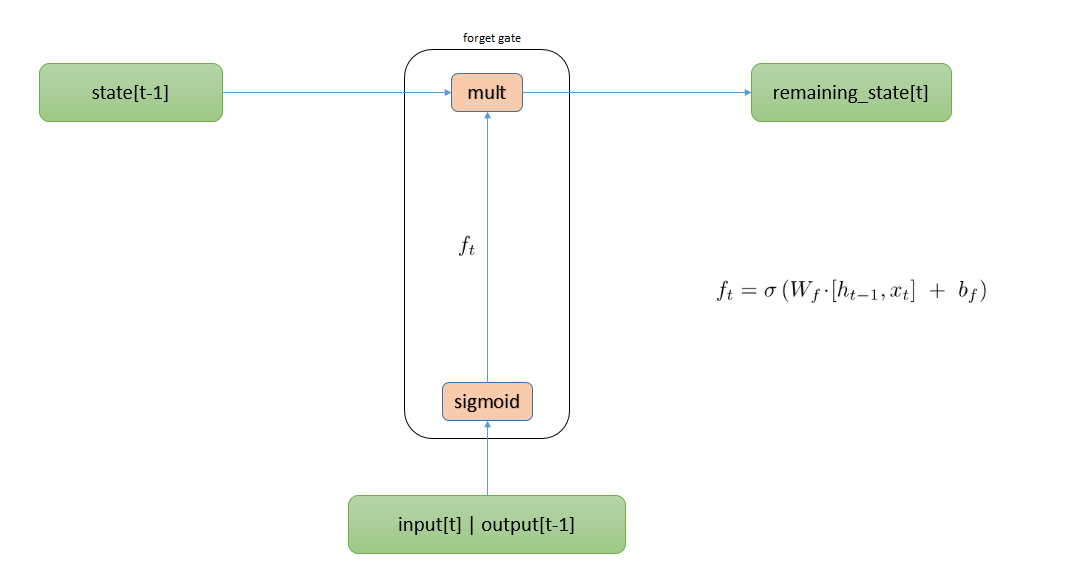

Image credit: https://miro.medium.com/v2/resize:fit:1400/1*hwWppCgUjseERF9K_BS6sA.png

In [2]:
class forget_gate(nn.Module):
  input_size : int
  hidden_size: int

  '''
  eqn of forget gate:
     f_t= sigmoid(W * [h_prev,x_t] + b)

  '''


  @nn.compact

  def __call__(self, h_prev: jnp.ndarray, x_t: jnp.ndarray) -> jnp.ndarray:

      concat_out = jnp.concatenate([h_prev, x_t], axis=-1)

      W = self.param(
          "W",
          jax.nn.initializers.glorot_uniform(),
          (self.input_size + self.hidden_size, self.hidden_size),
      )
      b = self.param(
          "b",
          jax.nn.initializers.zeros,
          (self.hidden_size,)
      )

      f_t_linear = jnp.dot(concat_out, W) + b
      f_t = nn.sigmoid(f_t_linear)

      return f_t



Q-1: woah what have we done here?

Okay well the dimensions of the weight matrix is of the form: [input_size + hidden_size ,hidden size]
why? its because the dimensions of h_prev which is the previous hidden state is **[hidden_size,]**
and the dimension of x_t which is the current input is **[input_size,]**
so when we are performing concatenation operation, the dimension becomes **[hidden_size + input_size,]**
and then when you multiply this with weight matrix, resulting dimension is **[input_size + hidden_size ,hidden size]**

then you do a dot product since both have different dimensions and we need a **vector** for each unit.
Then add bias to it and next you take the sigmoid of it.

easy peasy 😄😄


Q-2 : why did we use glorot_uniform()??

It keeps the scale of gradients roughly the same across all layers. Instead of random weight initialization we pick weights from a uniform distribution which is a better option.

# Now the Input Gate

In [3]:
'''
eqns for input gate:

i_t = sigmoid(W_i * [h_prev, x_t] + b_i)
C_t = tanh(W_c * [h_prev, x_t] + b_c)
'''

class input_gate(nn.Module):
  input_size : int
  hidden_size: int

  @nn.compact

  def __call__(self, h_prev: jnp.ndarray, x_t: jnp.ndarray) -> jnp.ndarray:

      concat_out = jnp.concatenate([h_prev, x_t], axis=-1)

      W_i = self.param(
          "W_i",
          jax.nn.initializers.glorot_uniform(),
          (self.input_size + self.hidden_size, self.hidden_size),
      )
      b_i = self.param(
          "b_i",
          jax.nn.initializers.zeros,
          (self.hidden_size,)
      )

      i_linear= jnp.dot(concat_out, W_i) + b_i
      i_t = nn.sigmoid(i_linear)

      #now tanh implementation

      W_c = self.param(
          "W_c",
          jax.nn.initializers.glorot_uniform(),
          (self.input_size + self.hidden_size, self.hidden_size),
      )
      b_c = self.param(
          "b_c",
          jax.nn.initializers.zeros,
          (self.hidden_size,)

      )
      c_linear = jnp.dot(concat_out, W_c) + b_c
      C_t = nn.tanh(c_linear)

      return i_t, C_t




# Now the Cell Update gate

In [4]:
'''
eqn for cell update gate:

C_U = f_t * C_prev + i_t * C_t
'''

class cell_update(nn.Module):

  @nn.compact
  def __call__(self, f_t: jnp.ndarray, C_prev: jnp.ndarray, i_t: jnp.ndarray, C_t: jnp.ndarray) -> jnp.ndarray:

    C_U = f_t * C_prev + i_t * C_t
    return C_U


In [5]:
'''
Output Gate:
o_t = sigmoid(W_o * [h_prev, x_t] + b_o)
h_t = o_t * tanh(C_U)
'''

class output_gate(nn.Module):
    input_size: int
    hidden_size: int

    @nn.compact
    def __call__(self, h_prev: jnp.ndarray, x_t: jnp.ndarray, C_U: jnp.ndarray) -> jnp.ndarray:

        concat_out = jnp.concatenate([h_prev, x_t], axis=-1)

        W_o = self.param(
            "W_o",
            jax.nn.initializers.glorot_uniform(),
            (self.input_size + self.hidden_size, self.hidden_size),
        )
        b_o = self.param(
            "b_o",
            jax.nn.initializers.zeros,
            (self.hidden_size,)
        )

        o_linear = jnp.dot(concat_out, W_o) + b_o
        o_t = nn.sigmoid(o_linear)

        h_t = o_t * nn.tanh(C_U)

        return h_t


# BANG!!
# We have built all the amazing gates of LSTM. But they are independent as of now, we need to merge them to form a complete structured LSTM unit

In [6]:
class LSTM(nn.Module):
    input_size: int
    hidden_size: int

    @nn.compact
    def __call__(
        self, h_prev: jnp.ndarray, C_prev: jnp.ndarray, x_t: jnp.ndarray
    ) -> tuple[jnp.ndarray, jnp.ndarray]:

        f_t = forget_gate(self.input_size, self.hidden_size)(h_prev, x_t)


        i_t, C_t = input_gate(self.input_size, self.hidden_size)(h_prev, x_t)


        C_U = cell_update()(f_t, C_prev, i_t, C_t)


        h_t = output_gate(self.input_size, self.hidden_size)(h_prev, x_t, C_U)

        return h_t, C_U


# SO WHAT DID WE JUST DO?

# we just coded a fully functional LSTM network from scratch in JAX

# Now let us process each sequence length which is what happens in the LSTM working

In [7]:
class LSTM_seq(nn.Module):
  input_size: int
  hidden_size: int
  seq_len: int

  @nn.compact
  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        batch_size = x.shape[0]

        hidden = jnp.zeros((batch_size, self.hidden_size))
        cell = jnp.zeros((batch_size, self.hidden_size))

        outputs = []

        lstm_cell = LSTM(self.input_size, self.hidden_size)

        for time in range(self.seq_len):
            hidden, cell = lstm_cell(hidden, cell, x[:, time, :])
            outputs.append(hidden)

        return jnp.stack(outputs, axis=1)


So what does this do?

okay so the shape of X is **[batch_size, sequence_length,input_size]**

so for the batch_size obviously we need the 1st dimension storing size of the batch

and then we use the loop:

         for time in range(self.seq_len):
              hidden, cell = lstm_cell(hidden, cell, x[:, time, :])
              outputs.append(hidden)

that is because LSTM process each input sequence at every timestep rather than altogether.

This is the forward pass of our LSTM net. For every timestep, we apply the 4 gates of LSTM and update our hidden and cell states.




# This is it for LSTM. We can use this created architecture for AI and NLP projects accordingly.
#Hope this tutorial was helpful in understanding how this fabulous network works under the hood😊